In [1]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

In [5]:
import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )


tf.__version__: 2.13.0
keras.__version__: 2.13.1


In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [8]:

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

In [9]:
# import images
!cd /content
data_dir = '/content/drive/My Drive/ads/dataset/'
file_list = os.listdir(data_dir)
angle_01 = []
angle_02 = []
angle_03 = []
pattern = "*.jpg"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
      angle = int(filename[-8:-4])
      if (angle == 1): angle_01.append(os.path.join(data_dir, filename))
      if (angle == 2): angle_02.append(os.path.join(data_dir, filename))
      if (angle == 3): angle_03.append(os.path.join(data_dir, filename))

In [10]:
train_list = [x for x in angle_01]
train_list.extend([x for x in angle_02])
train_list.extend([x for x in angle_03])
df_train = pd.DataFrame(np.concatenate([
                       ['1']*len(angle_01),
                       ['2']*len(angle_02),
                       ['3']*len(angle_03)]),
                        columns = ['label'])
df_train['image'] = [x for x in train_list]
df_train

,label,image
0,1,/content/drive/My Drive/ads/dataset/frame03_0700_0001.jpg
1,1,/content/drive/My Drive/ads/dataset/frame03_0543_0001.jpg
2,1,/content/drive/My Drive/ads/dataset/frame03_0591_0001.jpg
3,1,/content/drive/My Drive/ads/dataset/frame03_1080_0001.jpg
4,1,/content/drive/My Drive/ads/dataset/frame03_0862_0001.jpg
...,...,...
1420,3,/content/drive/My Drive/ads/dataset/frame03_1054_0003.jpg
1421,3,/content/drive/My Drive/ads/dataset/frame01_0256_0003.jpg
1422,3,/content/drive/My Drive/ads/dataset/frame01_0266_0003.jpg
1423,3,/content/drive/My Drive/ads/dataset/frame01_0255_0003.jpg


In [ ]:
path = '/content/drive/MyDrive/ads/dataset'

img_list = list(df_train['image'])
data_img = []
for each in img_list:
    each_path = os.path.join(path, each)
    image = cv2.imread(each_path)
    height, _, _ = image.shape
    image = image[int(height/5):,:,:]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,200))
    image = image / 255
    data_img.append(image)
X = np.array(data_img)

In [12]:
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))
y

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=int8)

In [13]:
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

Shape of X:  (1425, 200, 200, 3)
Shape of y:  (1425, 3)


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_valid.shape)
print('y_val shape  : ', y_valid.shape)

Training data: 1140
Validation data: 285
X_train shape:  (1140, 200, 200, 3)
y_train shape:  (1140, 3)
X_val shape  :  (285, 200, 200, 3)
y_val shape  :  (285, 3)


In [15]:
train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)


train_gen.fit(X_train)
validation_gen.fit(X_valid)

In [16]:
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16

def model():
    input_tensor = Input(shape=(200,200,3))
    vgg16 = VGG16(include_top=False,weights="imagenet",input_tensor=input_tensor)

    model = Sequential()
    model.add(Flatten(input_shape=vgg16.output_shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))
    model = Model(inputs=vgg16.input, outputs=model(vgg16.output))

    for layer in model.layers[:16]:
      layer.trainable = False
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

model_functional = model()
print(model_functional.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [17]:
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

model_output_dir = '/content/drive/My Drive/ads/model/'
epochs = 50
batch_size = 64
saved_model_path = os.path.join(model_output_dir, 'lane_navigation_check.h5')

# コールバック(early stopping、重みの保存)
ch_pt = callbacks.ModelCheckpoint(filepath=saved_model_path ,monitor='val_loss',save_best_only=True,save_weights_only=True)
es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
rd_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

if os.path.exists(saved_model_path):
    model = load_model(saved_model_path)
    initial_epoch = model.optimizer.iterations.numpy() // epochs
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0

history = model_functional.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_valid, y_valid), callbacks=[ch_pt,rd_lr,es_cb])

model.save(os.path.join(model_output_dir, 'lane_navigation_final.h5'))

Epoch 1/50
18/18 [==============================] - 39s 1s/step - loss: 3.7168 - accuracy: 0.3982 - val_loss: 0.9933 - val_accuracy: 0.4175 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 6s 351ms/step - loss: 0.9113 - accuracy: 0.5789 - val_loss: 0.7119 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 6s 349ms/step - loss: 0.6443 - accuracy: 0.7465 - val_loss: 0.5763 - val_accuracy: 0.7719 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 6s 357ms/step - loss: 0.4905 - accuracy: 0.8053 - val_loss: 0.5149 - val_accuracy: 0.8035 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 6s 351ms/step - loss: 0.5254 - accuracy: 0.8053 - val_loss: 0.6523 - val_accuracy: 0.7123 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 11s 647ms/step - loss: 0.3960 - accuracy: 0.8430 - val_loss: 0.4226 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 7/50
18/18 [==============================] - 6s 350ms/step - los

AttributeError: ignored

ValueError: ignored

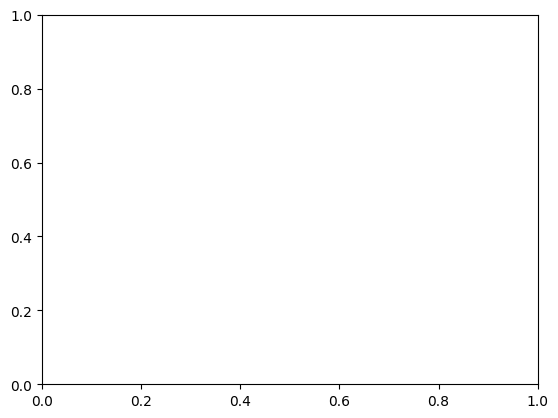

In [19]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

plt.plot(np.arange(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()
